In [60]:
# q_vis_response_plotter.ipynb
# Avery Krieger 05/23/2023

# Adapts code from uniform_flash.py to analyize and plot the AstA-->Chrimson, GCaMP
# vis responses

%load_ext autoreload
%autoreload 2

from visanalysis.analysis import imaging_data, shared_analysis
from visanalysis.util import plot_tools

from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

import os
import numpy as np
from pathlib import Path

from scipy.interpolate import interp1d

# Load in flies
folder_path = "/Volumes/ABK2TBData/data_repo/bruker/20230519.selected"
exp_date = "2023-05-19"

asta_fly1_prox = [folder_path, exp_date, "6", "medulla_terminals_all"]
asta_fly2_prox = [folder_path, exp_date, "9", "medulla_terminals_all"]
#asta_fly2_prox_comp1 = [folder_path, exp_date, "9", "medulla_terminals_comp8"]



asta_prox_all = [asta_fly1_prox, asta_fly2_prox,]
asta_fly_list = [1, 2]

# Housekeeping:
condition_name = 'current_intensity'
save_directory = "/Volumes/ABK2TBData/lab_repo/analysis/outputs/q_vis_response/"
Path(save_directory).mkdir(exist_ok=True)


# Function that takes in a fly and outputs the trial data
def getTrialData(fly, return_more=False):
    file_path = os.path.join(fly[0], fly[1] + ".hdf5")
    ID = imaging_data.ImagingDataObject(file_path, fly[2], quiet=True)
    roi_data = ID.getRoiResponses(fly[3])
    time_vector = roi_data['time_vector']
    unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity = ID.getTrialAverages(roi_data.get('epoch_response'), parameter_key=condition_name)

    if return_more:
        return unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity, time_vector, ID
    
    else:
        return unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity, time_vector

def visFlash(ID):
    flash_start = ID.getRunParameters('pre_time')
    flash_width = ID.getRunParameters('stim_time')
    flash_end = flash_start + flash_width
    
    return flash_start, flash_end

# create ID object and call visFlash
unique_parameter_values, _, _, _, _, ID = getTrialData(asta_fly1_prox, return_more=True)
flash_start, flash_end = visFlash(ID)

flash_types = ['Dark', 'Light']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plot individual ROIs

unique_parameter_values: [[0.0], [1.0]]
unique_parameter_values: [[0.0], [1.0]]


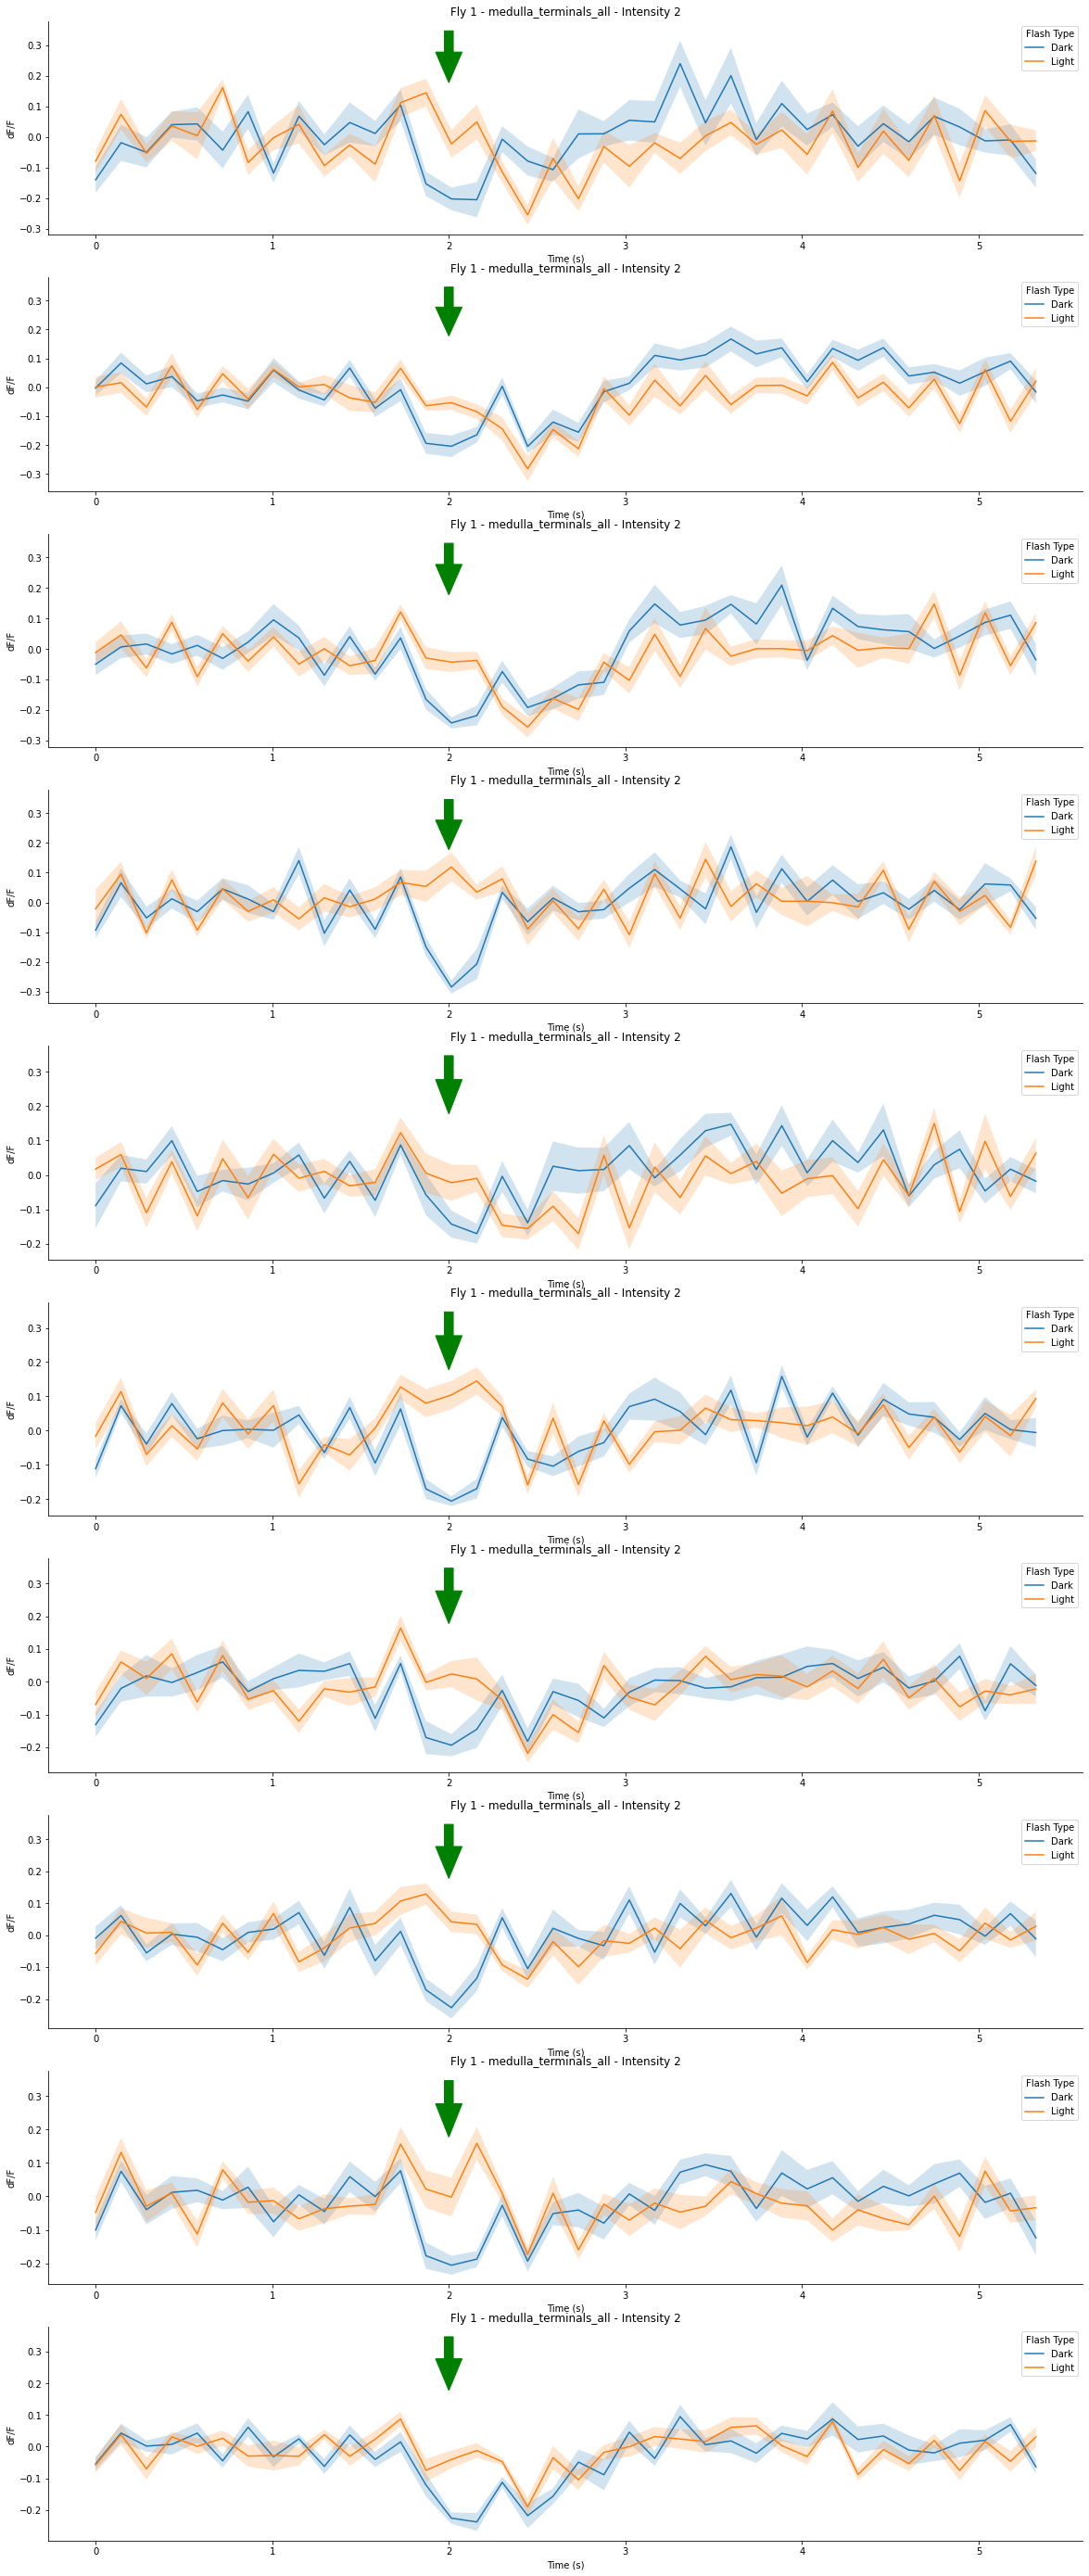

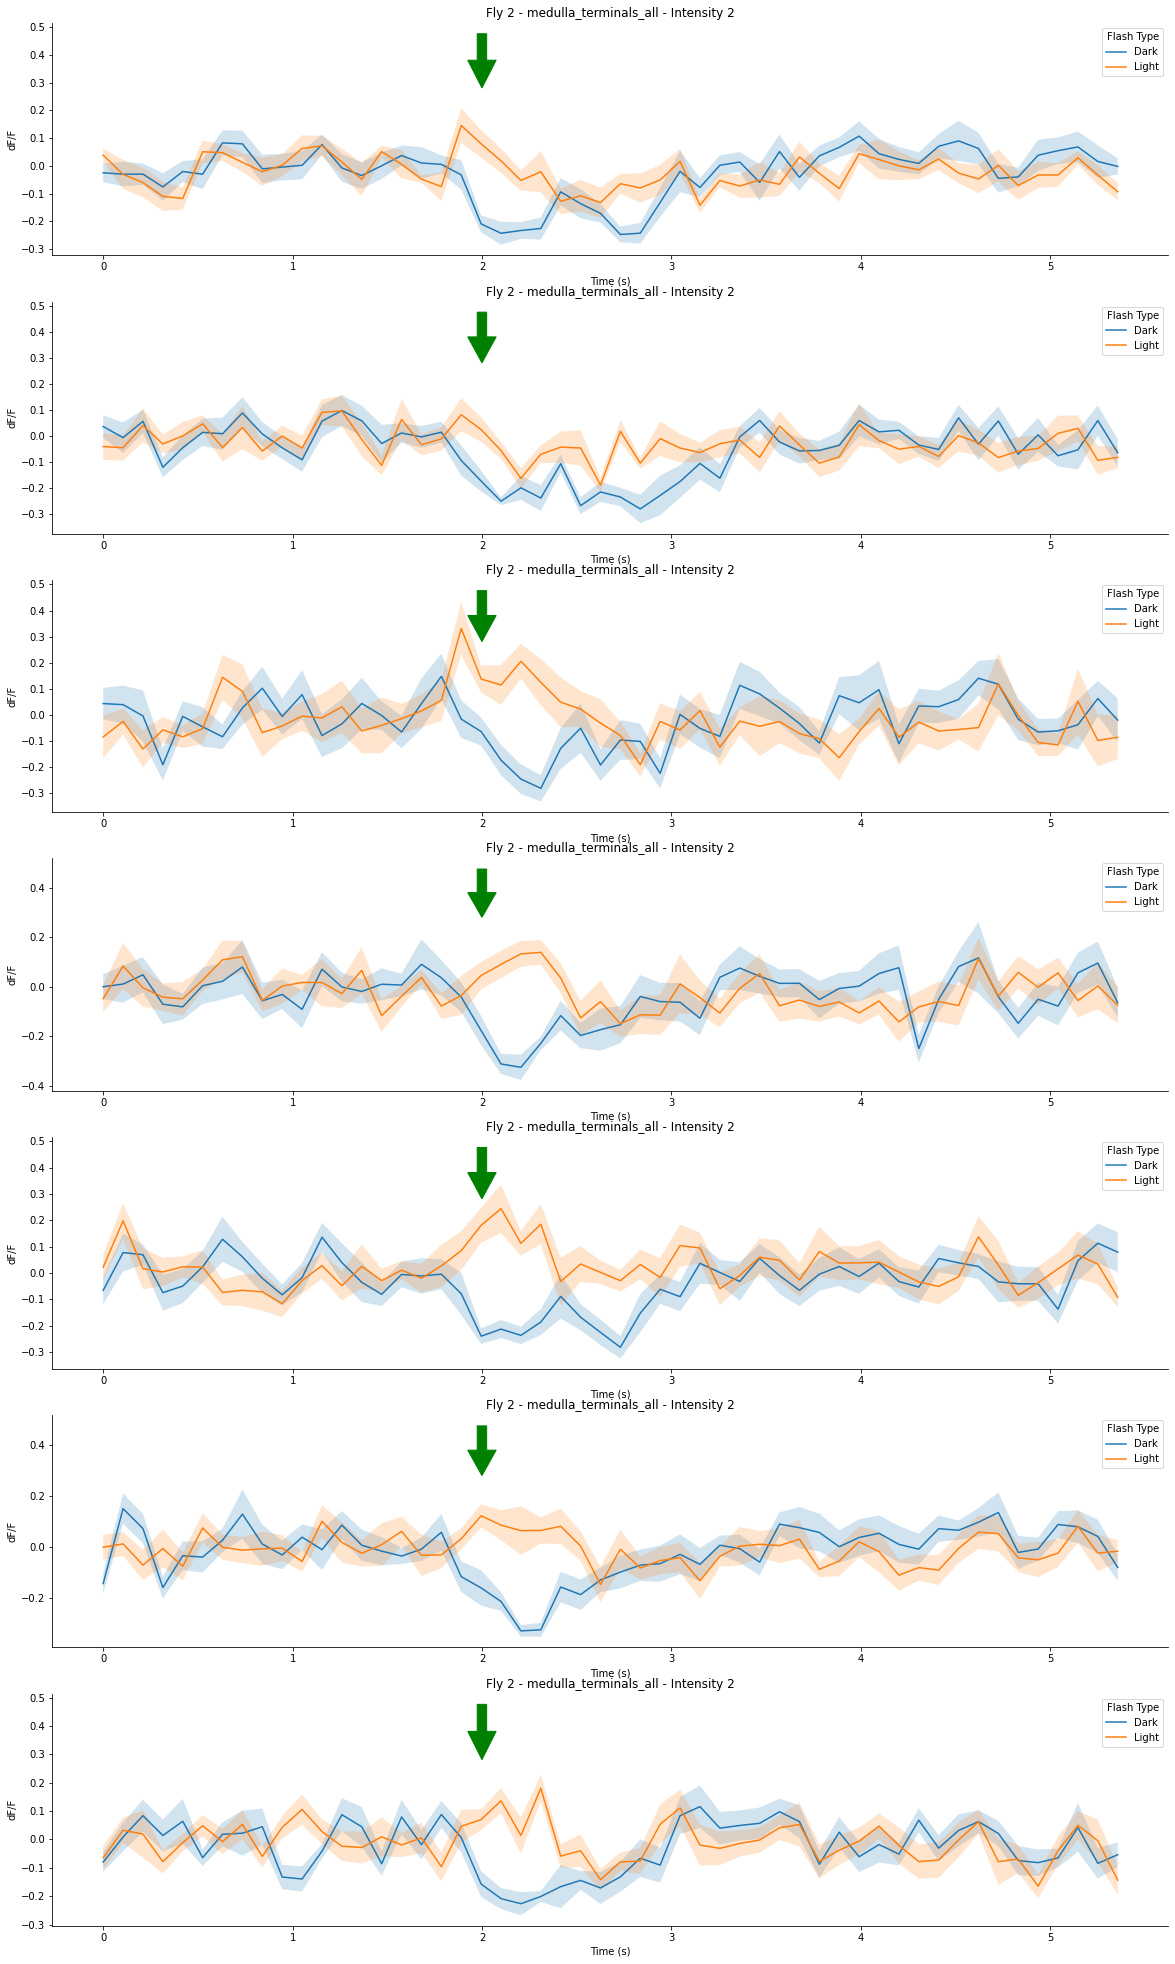

In [70]:
# Call function to get trial data for each fly
for fly_ind in range(len(asta_prox_all)):
    unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity, time_vector = getTrialData(asta_prox_all[fly_ind])
    print(f'unique_parameter_values: {unique_parameter_values}')
    # calculate the min and max values for vis stim plotting
    min_val = np.min(mean_response-sem_response)*1.1
    max_val = np.max(mean_response+sem_response)*1.1


    fig, ax = plt.subplots(len(mean_response), 1, figsize=(20, 5*len(mean_response)))
    for roi_ind in range(len(mean_response)):
        # for each opto intensity
        for intensity_ind in range(len(unique_parameter_values)):
            # plot the mean response
            ax[roi_ind].plot(time_vector, mean_response[roi_ind][intensity_ind], label=flash_types[intensity_ind])
            # plot the SEM
            ax[roi_ind].fill_between(time_vector, mean_response[roi_ind][intensity_ind] - sem_response[roi_ind][intensity_ind], mean_response[roi_ind][intensity_ind] + sem_response[roi_ind][intensity_ind], alpha=0.2)
            
        # plot the vis flash
        ax[roi_ind].arrow(flash_start, max_val, 
                 0, max_val*-0.2, 
                 width=0.05,
                 head_length=0.1,
                 color='g',
                 )
            
        ax[roi_ind].set_title('Fly ' + str(asta_fly_list[fly_ind]) + ' - ' + str(asta_prox_all[fly_ind][3]) + ' - Intensity ' + str(intensity_ind+1))
        ax[roi_ind].set_xlabel('Time (s)')
        ax[roi_ind].set_ylabel('dF/F')
        ax[roi_ind].legend(title='Flash Type', loc='upper right')
        ax[roi_ind].spines['top'].set_visible(False)
        ax[roi_ind].spines['right'].set_visible(False)

In [48]:
plt.close('all')

## Plot averages across ROIs

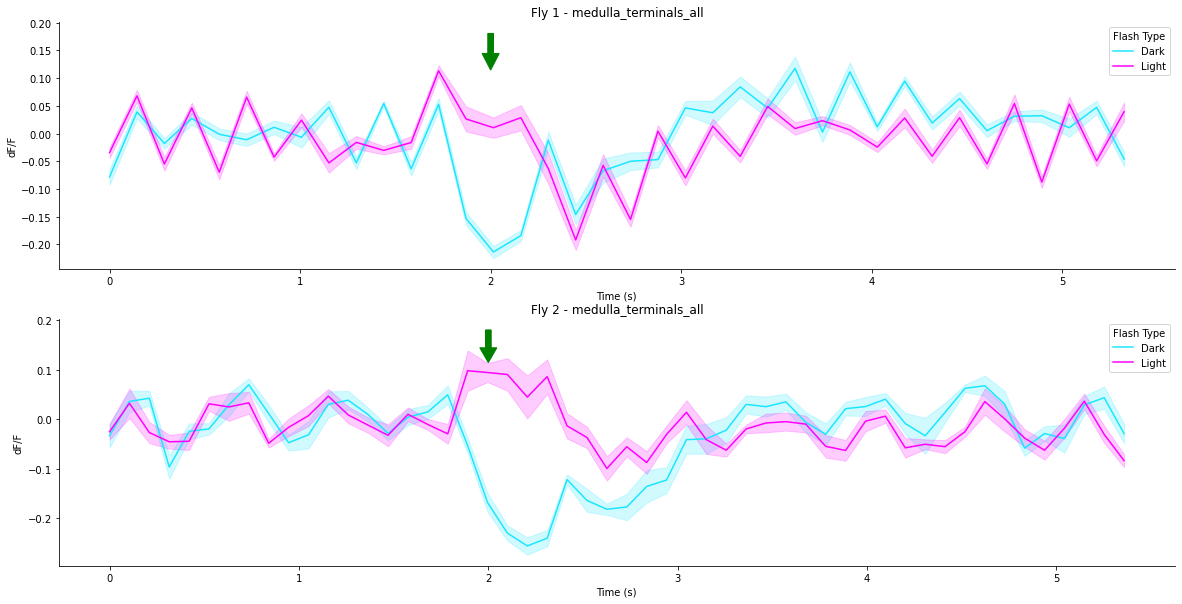

In [56]:
# create subplots for each fly
cmap = plt.get_cmap('cool') # also 'cool' 'winter' 'PRGn' 'Pastel1' 'YlGnBu' 'twilight'
colors = [cmap(i) for i in np.linspace(0.1, 1.0, len(flash_types))]
fig, ax = plt.subplots(len(asta_prox_all), 1, figsize=(20, 5*len(asta_prox_all)))

for fly_ind in range(len(asta_prox_all)):
    unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity, time_vector = getTrialData(asta_prox_all[fly_ind])
    
    # calculate mean across ROIs
    mean_response_cross_ROI = np.mean(mean_response, axis=0)
    # calculate SEM
    sem = np.std(mean_response, axis=0)/np.sqrt(len(mean_response))
    sem_plus = mean_response_cross_ROI + sem
    sem_minus = mean_response_cross_ROI - sem
    max_val = np.max(sem_plus)*1.3
    

    for intensity_ind in range(len(flash_types)):
        # plot the mean response
        ax[fly_ind].plot(time_vector, mean_response_cross_ROI[intensity_ind], label=flash_types[intensity_ind], color=colors[intensity_ind])
        # plot the SEM
        ax[fly_ind].fill_between(time_vector, sem_minus[intensity_ind], sem_plus[intensity_ind], alpha=0.2, color=colors[intensity_ind])

    # plot the vis flash
    ax[fly_ind].arrow(flash_start, max_val, 
                0, max_val*-0.2, 
                width=0.03,
                head_length=0.03,
                color='g',
                )
            
    ax[fly_ind].set_title('Fly ' + str(asta_fly_list[fly_ind]) + ' - ' + str(asta_prox_all[fly_ind][3]))
    ax[fly_ind].set_xlabel('Time (s)')
    ax[fly_ind].set_ylabel('dF/F')
    ax[fly_ind].legend(title='Flash Type', loc='upper right')
    ax[fly_ind].spines['top'].set_visible(False)
    ax[fly_ind].spines['right'].set_visible(False)

(27, 2, 52)
mean_response_cross_ROI shape: (2, 52)


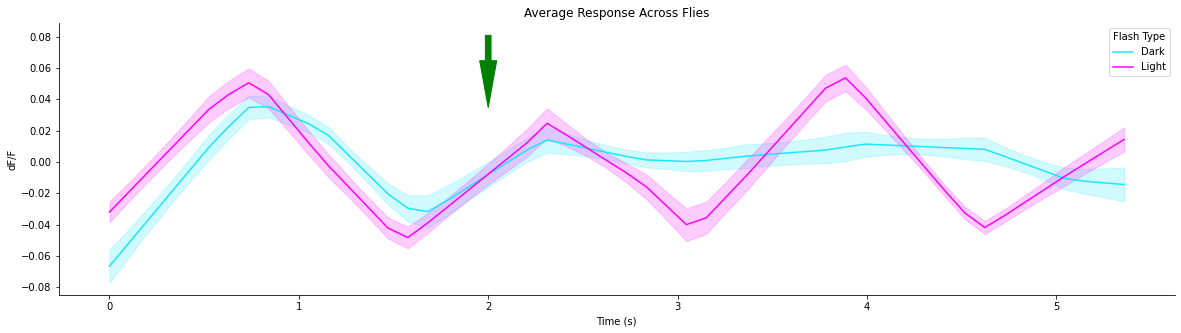

In [69]:
# Average over all the flies and plot
# create subplots for each fly

response_cross_fly = []

fig, ax = plt.subplots(1, 1, figsize=(20, 5))

for fly_ind in range(len(asta_prox_all)):
    unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity, time_vector = getTrialData(asta_prox_all[fly_ind])

    # interpolate the mean response to 52 time points
    f = interp1d(time_vector, mean_response, axis=-1)
    mean_response = f(np.linspace(0, 1, 52))
    if fly_ind == 0:
        response_cross_fly = mean_response
    response_cross_fly = np.append(response_cross_fly, mean_response, axis=0)

# calculate mean and sem across all ROIs and flies
print(response_cross_fly.shape)
mean_response_cross_ROI = np.mean(response_cross_fly, axis=0)
print(f'mean_response_cross_ROI shape: {mean_response_cross_ROI.shape}')
sem = np.std(response_cross_fly, axis=0)/np.sqrt(len(response_cross_fly))
sem_plus = mean_response_cross_ROI + sem
sem_minus = mean_response_cross_ROI - sem
max_val = np.max(sem_plus)*1.3

for intensity_ind in range(len(flash_types)):
    # plot the mean response
    ax.plot(time_vector, mean_response_cross_ROI[intensity_ind], label=flash_types[intensity_ind], color=colors[intensity_ind])
    # plot the SEM
    ax.fill_between(time_vector, sem_minus[intensity_ind], sem_plus[intensity_ind], alpha=0.2, color=colors[intensity_ind])

# plot the vis flash
ax.arrow(flash_start, max_val,
            0, max_val*-0.2,
            width=0.03,
            head_length=0.03,
            color='g',
            )

ax.set_title('Average Response Across Flies')
ax.set_xlabel('Time (s)')
ax.set_ylabel('dF/F')
ax.legend(title='Flash Type', loc='upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

    
